# Chapter 2.1

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter2_1()
# This is needed to render the plots in this chapter
from plots.chapter2_1 import *

In [2]:
import numpy as np
import datetime

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# Going Classy

## The Class

In [3]:
# A completely empty (and useless) class
class StepByStep(object):
    pass

## The Constructor

### Arguments

In [4]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Send the model to the specified device
        self.model.to(self.device)
        
        # Placeholders
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # Variables - Those will be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0
        
        # Creates the train_step function for model, loss_fn and optimizer
        self.train_step_fn = self._make_train_step_fn()
        
        # Creates the val_step function for model, loss_fn
        self.val_step_fn = self._make_val_step_fn()
    
    # REPRODUCIBILITY
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    # SET METHODS
    
    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in the mini-batches)
        # and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f'Could not send it to {device}, \
                    sending it to {self.device} instead')
            self.model.to(self.device)
            
            
    def set_loaders(self, train_loader, val_loader=None):
        # this method allows the user to define which train_loader
        # (val_loader optional) 
        # Loaders are assigned to class attributes
        self.train_loader = train_loader
        self.val_loader = val_loader
    
    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to creaate a SummaryWriter to
        # interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')
    
    # STEP METHODS
        
    def _make_train_step_fn(self):
        # This method does not need ARGS
        # we use the class attributes self.model, self.loss_fn and self.optimizer
        
        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to train mode
            self.model.train()
            
            # Step 1- Compute predictions
            yhat = self.model(x)
            
            # Step 2 - Compute loss
            loss = self.loss_fn(yhat, y)
            
            # Step 3 - Compute Gradients
            loss.backward()
            
            # Step 4 - Update parameters
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            # returns the loss
            return loss.item()
        
        # Returns the train step function
        return perform_train_step_fn
    

    def _make_val_step_fn(self):
        
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()
            
            # Step 1 - Compute Predictions
            yhat = self.model(x)
            
            # Step 2 - Compute Val Loss
            loss = self.loss_fn(yhat, y)
            
            # Return loss, no update parameter in evaluation
            return loss.item()
    
        return perform_val_step_fn
    
    
    # TRAINING METHODS
    
    def _mini_batch(self, validation=False):
        # The mini-batch function can be used with both loaders
        # The argument `validation` defines which loader and
        # corresponding step function are going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn
        
        if data_loader is None:
            return None
        
        # Once data loader and step function are set , this is the
        # same mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            
            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)
            
        loss = np.mean(mini_batch_losses)
        
        return loss
    
    
    # TRAINING LOOP
    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the number of epochs
            self.total_epochs += 1

            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})

                # Records both losses for each epoch under tag 'loss'
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Flushes the writer
            self.writer.flush()
                
        
    
    # SAVING AND LOADING METHODS
    
    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {
            'epoch': self.total_epochs,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': self.losses,
            'val_loss': self.val_losses
        }
        
        torch.save(checkpoint, filename)
        
    
    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)
        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']
        self.model.train() # always use TRAIn for resuming training
        
    
    # MAKING PREDICTIONS METHODS
    def predict(self, x):
        # Set it to evaluation mode for predictions
        self.model.eval()
        
        # Take a Numpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        
        # Send input to device and use model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        
        # Set model back to train mode
        self.model.train()
        
        # Detach yhat tensor, bring it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()
    
    
    # VISUALISATION METHODS
    def plot_losses(self):
        fig = plt.figure(figsize=(7, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        if self.val_loader:
            plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig
    
    
    def add_graph(self):
        if self.train_loader and self.writer:
            # Fetches a single mini-batch so we can use add_graph
            x_dummy, y_dummy = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_dummy.to(self.device))
    
    

## Classy Pipeline

In [5]:
# Runs data generation - so we do not need to copy code here
%run -i data_generation/simple_linear_regression.py

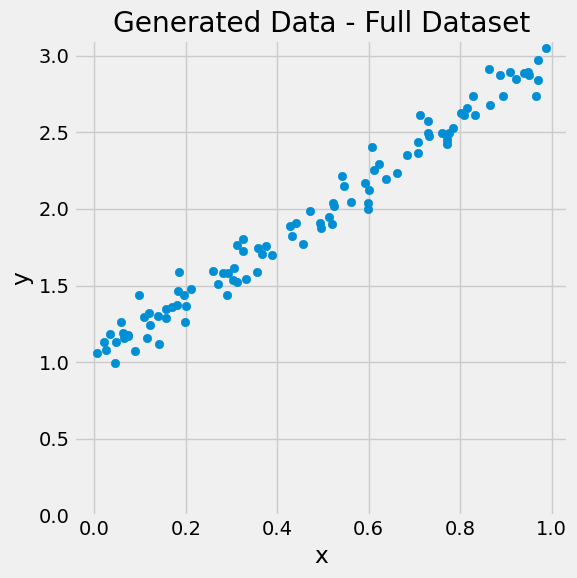

In [6]:
fig = figure1(x, y)

### Data Preparation V2

In [7]:
# %load data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

### Model Configuration V4

In [8]:
%%writefile model_configuration/v4.py

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1))

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

Overwriting model_configuration/v4.py


In [9]:
%run -i model_configuration/v4.py

<Figure size 640x480 with 0 Axes>

In [10]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])


## Model Training

In [11]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')

In [12]:
print(sbs.model == model)

True


In [13]:
print(sbs.model)

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)


In [14]:
sbs.train(n_epochs=200)
print(sbs.model.state_dict())
print(sbs.total_epochs)

OrderedDict([('0.weight', tensor([[1.9416]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])
200


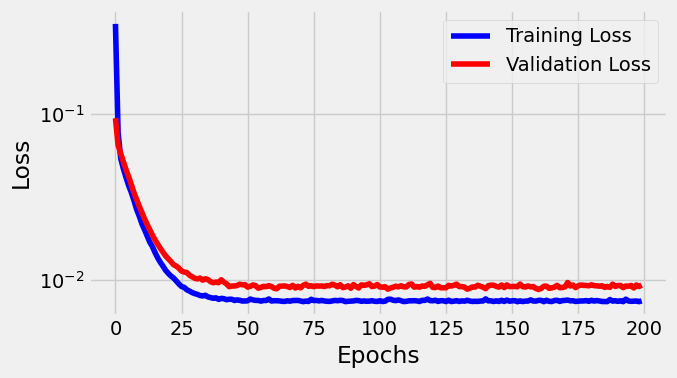

In [15]:
fig = sbs.plot_losses()

### Making Predictions

In [16]:
new_data = np.array([.5, .3, .7]).reshape(-1, 1)
new_data

array([[0.5],
       [0.3],
       [0.7]])

In [17]:
predictions = sbs.predict(new_data)
predictions

array([[1.9942763],
       [1.605955 ],
       [2.3825977]], dtype=float32)

### Checkpointing

### Cell 2.1.3

In [18]:
sbs.save_checkpoint('model_checkpoint.pth')

### Resuming Training

In [19]:
%run -i model_configuration/v4.py

<Figure size 640x480 with 0 Axes>

In [20]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])


### Cell 2.1.4

In [21]:
new_sbs = StepByStep(model, loss_fn, optimizer)

### Cell 2.1.5

In [22]:
new_sbs.load_checkpoint('model_checkpoint.pth')
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9416]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


### Cell 2.1.6

In [23]:
new_sbs.set_loaders(train_loader, val_loader)
new_sbs.train(n_epochs=50)

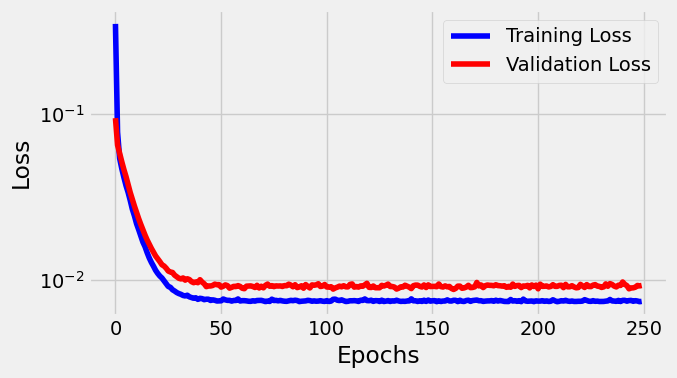

In [24]:
fig = new_sbs.plot_losses()

In [25]:
print(sbs.model.state_dict())

OrderedDict([('0.weight', tensor([[1.9416]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])
